In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *

c:\Users\matti\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataclass for adding problem

class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

## Creating dataset for first problem

First problem is seeing how the RNN trains to just add a list of numbers in time together

In [3]:
n_data = 1000
t_steps = 10

data,labels = datagen_full_sum_normal(n_data,t_steps,normalize=True)
# data,labels = datagen_timewise_labels(n_data,t_steps,2)
# print(data[1],labels[1])


BATCH_SIZE = 16

training_data = Datamodel(data,labels)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

data.shape

print(data[100].sum())

tensor(1.)


### Training first non-regualrized model

In [4]:
hidden_size = 1
input_size = 1
output_size = 1

train1 = False

# Run multiple times to see the effect of the random initialization
if train1:
    model = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False)
    _ = model.train(training_loader,epochs=100)
    model.plot_losses(average=30)
    # model.plot_accs()
    print(f"Init weights: Wh = {model.Wh_init}, Wx = {model.Wx_init}")
    print("Guess on the first 15 training data: ",model(data[0:15]))
    print("Weight of the hidden layer Wh: ",model.rnn.weight_hh_l0, " Weight of the input layer Wx: ",model.rnn.weight_ih_l0)

Both our weight matrices are close to 1, which means it counts on a line. Find that if $W_x$ is initialized as a negative number the model will train very little and the weights barely change from the initialized values. This is because of ReLU where if we have a negative input weight we will end up with 0, and with just one hidden dimension the signal will die.

### Multidimensional hidden layer h

Wx_norm:  tensor([[1.]])
Guess on the first 15 training data:  tensor([0.9116, 0.9618, 0.8718, 0.9192, 0.8864, 0.8932, 0.8621, 0.8913, 0.8570,
        0.9381, 0.9368, 0.8582, 0.9041, 0.8275, 0.8548],
       grad_fn=<NormBackward1>)


100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


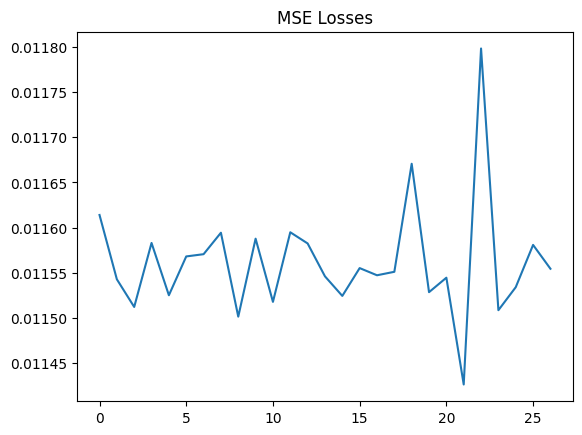

Guess on the first 15 training data:  tensor([0.9116, 0.9618, 0.8718, 0.9192, 0.8864, 0.8932, 0.8621, 0.8913, 0.8570,
        0.9381, 0.9368, 0.8582, 0.9041, 0.8275, 0.8548],
       grad_fn=<NormBackward1>)


In [5]:
hidden_size = 100
input_size = 1
output_size = 1

train2 = True

if train2:
    # model2 = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.01,irnn=True,outputnn=False,Wx_normalize=True)
    model2 = torch_RNN_manual(input_size,t_steps,output_size,hidden_size,lr=0.01,irnn=True,outputnn=False,Wx_normalize=True,activation=False)
    print("Guess on the first 15 training data: ", model2(data[0:15]))
    _ = model2.train(training_loader,epochs=100)
    model2.plot_losses(average=30)
    # model2.plot_accs()
    print("Guess on the first 15 training data: ", model2(data[0:15]))
    # print("Weight of the hidden layer: ",model2.rnn.weight_hh_l0, " Weight of the input layer: ",model2.rnn.weight_ih_l0)

In [6]:
# SVD of the weight matrix Wh

Wh = model2.rnn.weight_hh_l0.detach().numpy()
U, s, Vh = np.linalg.svd(Wh)
print("Singular values of Wh: ",s)

np.prod(s)

Singular values of Wh:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


1.0

In [7]:
# Sjekker om Wh beholder normen til x
x = np.random.uniform(size=100)
print(np.linalg.norm(Wh @ x))
print(np.linalg.norm(x))

5.910788590551914
5.910788590551914


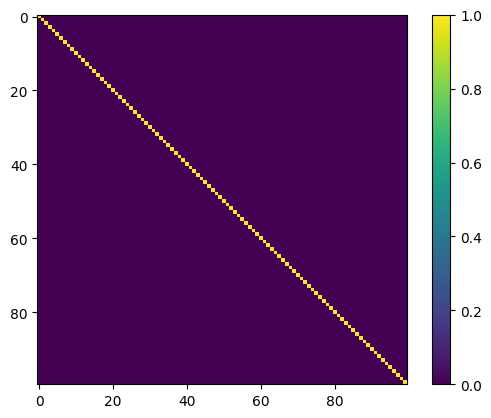

In [8]:
plt.imshow(Wh.T@Wh)
plt.colorbar()

PCA variance ratio:  [0.01010102 0.01010102]
PCA singular values:  [1.0000007 1.0000007]
PCA noise:  0.009997939


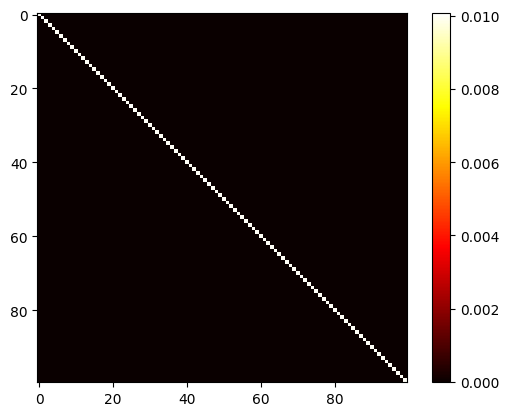

Singular values of Wh_pca:  [1.0000005 1.0000001]


In [9]:
import numpy as np
from sklearn.decomposition import PCA

# PCA of the weight matrix Wh

pca = PCA(n_components=2)
pca.fit(Wh)
print("PCA variance ratio: ",pca.explained_variance_ratio_)
print("PCA singular values: ",pca.singular_values_)
# print("PCA components: ",pca.components_)
# print("PCA mean: ",pca.mean_)
print("PCA noise: ", pca.noise_variance_)

covariance = pca.get_covariance()

# Plot the covariance matrix

plt.imshow(covariance, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

Wh_pca = pca.transform(Wh)

# SVD of Wh_pca

U, s, Vh = np.linalg.svd(Wh_pca)
print("Singular values of Wh_pca: ",s)

In [10]:
print(model2.Wx_init.norm())

tensor(0.5768)


PCA singular values:  [1. 1.]


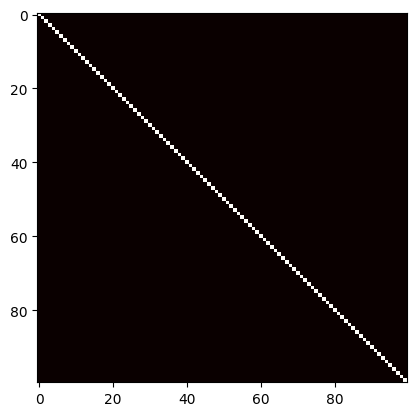

In [11]:
# PCA of randomly initialized weight matrix Wh

pca = PCA(n_components=2)
pca.fit(model2.Wh_init)
print("PCA singular values: ",pca.singular_values_)

plt.imshow(pca.get_covariance(), cmap='hot', interpolation='nearest')

Checking if model counts linearly

In [12]:
# model2.hts_last.shape
model2.hts_last.norm(dim=2).shape
htss = model2.hts_last.norm(dim=2)
plt.plot(htss.detach().numpy().T)

AttributeError: 'torch_RNN_manual' object has no attribute 'hts_last'

In [ ]:
# Norm of Wx

Wx = model2.rnn.weight_ih_l0.detach().numpy()
print("Norm of Wx: ",np.linalg.norm(Wx))

Norm of Wx:  1.0


Do find that $W_h$ has only one relatively large singular value, and find that $W_x$ has norm around 1. The covariance matrix creates a cross around one of the largest values.

In [ ]:
print(Wx-model2.Wx_init.numpy())

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
